In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#importing dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
paths2 = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.MW.nc"]
#ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
#ds2 = xr.open_mfdataset(paths2, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds2 = xr.open_mfdataset(paths2,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


In [3]:
power_density = 6

grdpnt_power = 13.5*27.5*power_density
turbine_rating = 8.3 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt))
print()

grdpnt_power = 13.5*27.5*power_density
turbine_rating2 = 8.0 #MW
n_turbs_grdpnt2 = grdpnt_power/turbine_rating2
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating2,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt2))





Total Power: 2227.5 MW per grid point
Turbine Rating: 8.3 MW
Number of Turbines per grid point: 268

Total Power: 2227.5 MW per grid point
Turbine Rating: 8.0 MW
Number of Turbines per grid point: 278


Spatial resolution for this data is 0.25 latitude x 0.25 longitude, however the area of each cell will change as a function of lattitude 

In [6]:

# Example usage with multiple latitudes
latitude_resolution = 0.25
longitude_resolution = 0.25
#latitudes = [50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0]  # Replace with the desired latitudes
latitudes = np.linspace(50,70,100)

grid_cell_areas = calculate_grid_cell_area(latitude_resolution, longitude_resolution, latitudes)

for latitude, area in zip(latitudes, grid_cell_areas):
    print(f"Area of the grid cell at latitude {latitude} is approximately {area:.2f} square kilometers.")


NameError: name 'calculate_grid_cell_area' is not defined

In [7]:

def calculate_grid_cell_area(latitude_resolution, longitude_resolution, latitudes):
    # Constants
    radius_of_earth = 6371  # Radius of the Earth in kilometers

    # Convert latitudes from degrees to radians
    latitudes_radians = [math.radians(lat) for lat in latitudes]

    # Calculate the length of 1 degree of latitude at the given latitudes
    lat_lengths = [111.32 for _ in latitudes]  # Length of 1 degree of latitude in kilometers for each latitude
    lon_lengths = [111.32 * math.cos(phi) for phi in latitudes_radians]  # Length of 1 degree of longitude in kilometers for each latitude

    # Calculate the area of the grid cell for each latitude
    areas = [lat_length * latitude_resolution * lon_length * longitude_resolution for lat_length, lon_length in zip(lat_lengths, lon_lengths)]

    # Calculate the average grid cell area
    average_area = np.mean(areas)

    return average_area

# Example usage with multiple latitudes
latitude_resolution = 0.25
longitude_resolution = 0.25
#latitudes = [50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0]  # Replace with the desired latitudes
latitudes = np.linspace(50, 70, 100)

average_grid_cell_area = calculate_grid_cell_area(latitude_resolution, longitude_resolution, latitudes)

print(f"Average area of the grid cells is approximately {average_grid_cell_area:.2f} square kilometers.")


Average area of the grid cells is approximately 385.25 square kilometers.


In [8]:
power_density = 6
area_of_grid = average_grid_cell_area

grdpnt_power = area_of_grid*power_density
turbine_rating = 8.3 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt))
print()

grdpnt_power = area_of_grid*power_density
turbine_rating2 = 8.0 #MW
n_turbs_grdpnt2 = grdpnt_power/turbine_rating2
loss_factor = 0.9 #energy lost due to wind turbines in farms


print('Total Power:',grdpnt_power,'MW per grid point')
print('Turbine Rating:',turbine_rating2,'MW')
print('Number of Turbines per grid point:',int(n_turbs_grdpnt2))





Total Power: 2311.5106268080654 MW per grid point
Turbine Rating: 8.3 MW
Number of Turbines per grid point: 278

Total Power: 2311.5106268080654 MW per grid point
Turbine Rating: 8.0 MW
Number of Turbines per grid point: 288


In [9]:

#Group 0
coords = np.empty((5,5,2))
coords[0,0,:] = np.array([66, 13])
coords[0,1,:] = np.array([57.5, 10])
coords[0,2,:] = np.array([53, 5.0])
coords[0,3,:] = np.array([60, 5])
coords[0,4,:] = np.array([66, 13])




#Group 1
lat = 58
lon = 10
coords[1,0,:] = np.array([lat+0.25, lon])
coords[1,1,:] = np.array([lat, lon+0.25])
coords[1,2,:] = np.array([lat, lon-0.25])
coords[1,3,:] = np.array([lat+0.25, lon-0.25])
coords[1,4,:] = np.array([lat+0.25, lon+0.25])

#Group 2
lat = 61
lon = -5
coords[2,0,:] = np.array([lat+0.25, lon])
coords[2,1,:] = np.array([lat, lon+0.25])
coords[2,2,:] = np.array([lat, lon-0.25])
coords[2,3,:] = np.array([lat+0.25, lon-0.25])
coords[2,4,:] = np.array([lat+0.25, lon+0.25])

#Group 4

lat = 51
lon = -7
coords[3,0,:] = np.array([lat+0.25, lon])
coords[3,1,:] = np.array([lat, lon+0.25])
coords[3,2,:] = np.array([lat, lon-0.25])
coords[3,3,:] = np.array([lat+0.25, lon-0.25])
coords[3,4,:] = np.array([lat+0.25, lon+0.25])

lat = 66
lon = 7
coords[4,0,:] = np.array([lat+0.25, lon])
coords[4,1,:] = np.array([lat, lon+0.25])
coords[4,2,:] = np.array([lat, lon-0.25])
coords[4,3,:] = np.array([lat+0.25, lon-0.25])
coords[4,4,:] = np.array([lat+0.25, lon+0.25])

coords = (np.round(coords*4, decimals=0)/4)
print(coords)

color = ['r','b','g','m',"c"]

[[[66.   13.  ]
  [57.5  10.  ]
  [53.    5.  ]
  [60.    5.  ]
  [66.   13.  ]]

 [[58.25 10.  ]
  [58.   10.25]
  [58.    9.75]
  [58.25  9.75]
  [58.25 10.25]]

 [[61.25 -5.  ]
  [61.   -4.75]
  [61.   -5.25]
  [61.25 -5.25]
  [61.25 -4.75]]

 [[51.25 -7.  ]
  [51.   -6.75]
  [51.   -7.25]
  [51.25 -7.25]
  [51.25 -6.75]]

 [[66.25  7.  ]
  [66.    7.25]
  [66.    6.75]
  [66.25  6.75]
  [66.25  7.25]]]


In [10]:
# Print the latitude and longitude coordinates in the ds dataset
#print(ds.latitude)
#print(ds.longitude)




In [11]:
#over all time points for power stations grouped together
agg_power = dict()
for i in range(coords.shape[0]):
    lats = xr.DataArray(coords[i,:,0], dims='coords')
    lons = xr.DataArray(coords[i,:,1], dims='coords')
    agg_power[i] = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                    .sum(dim='coords')).compute()

In [12]:
#calculating firm capacity
N = 1000 #number of samples
ratios = np.linspace(0,1.0,N)

power_limit = ratios * 8300 * n_turbs_grdpnt * coords.shape[1]
firm_capacity = np.empty((coords.shape[0],ratios.shape[0]))
arr_length = agg_power[0].shape[0]

for j in range(coords.shape[0]):
    start= time.time()
    for i, ratio in enumerate(ratios):
        working_ds = agg_power[j]
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[j,i] = val/arr_length #proportion of values above the power limit
    end = time.time()
    #print(j,') Time taken for',ratios.shape[0],'calculations:',np.round((end-start),decimals=2),'secs')
    #print(firm_capacity[j,:])

The section above calculates the firm capacity of each wind farm, assuming each wind farm group has five coordinates forming a square with a side length of 0.5 degrees.

The section below plots these wind farm groups onto the same wind magnitude plot seen earlier

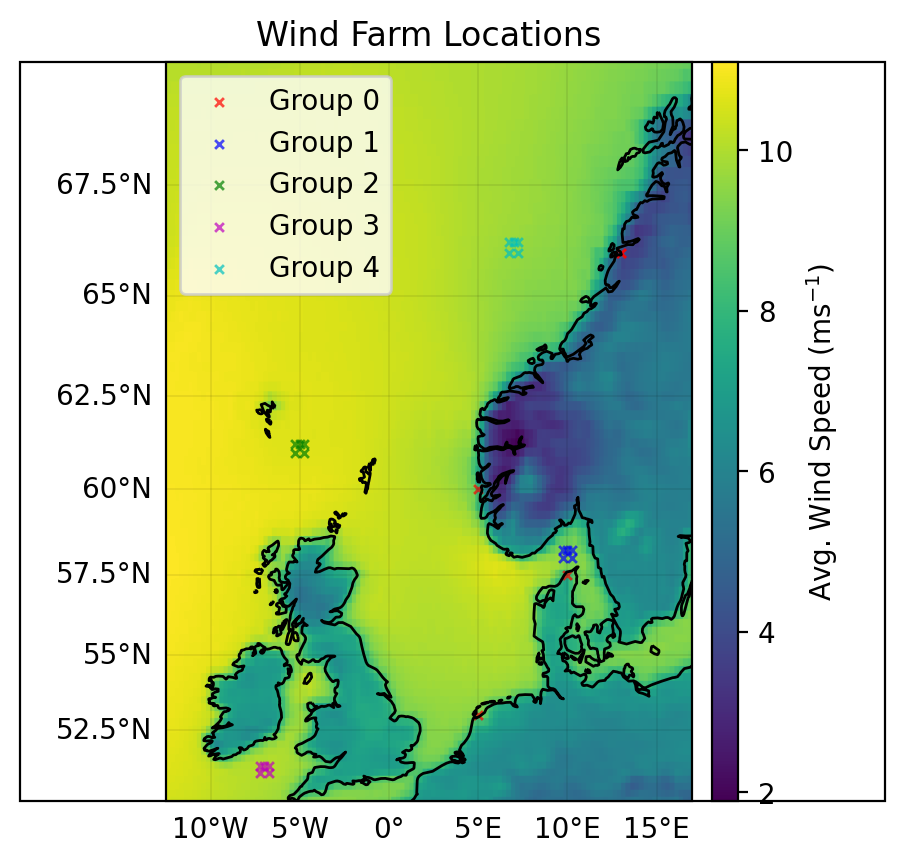

In [13]:
ds_mean = ds.mean(dim='time')['wind_mag'].transpose()
edge = -0.1

# Plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200, edgecolor='none')
ax = plt.axes(projection=ccrs.Mercator())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='black', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
plt.title('Wind Farm Locations')
ax.set_extent([ds.coords['longitude'][0], ds.coords['longitude'][-1],
               ds.coords['latitude'][0], ds.coords['latitude'][-1]], ccrs.PlateCarree())
ax.coastlines(resolution='50m')

for j in range(coords.shape[0]):
    plt.scatter(x=coords[j,:,1], y=coords[j,:,0], marker='x', color=color[j],
                s=10, alpha=.7, transform=ccrs.PlateCarree(), linewidth=1)

classes = ['Group 0', 'Group 1', 'Group 2', 'Group 3', 'Group 4']
plt.legend(loc='upper left', labels=classes)

img_extent = ([ds.coords['longitude'][0], ds.coords['longitude'][-1],
               ds.coords['latitude'][0]-edge, ds.coords['latitude'][-1]+edge])
z = ax.imshow(ds_mean, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)

fig.add_axes(ax_cb)
plt.colorbar(z, cax=ax_cb, label=r'Avg. Wind Speed (ms$^{-1}$)')
plt.show()



In [14]:
cap_fac_store = np.zeros((5,5))

print('Capacity factors:')
for j in range(coords.shape[0]):
    print('Group',j)
    for i in range(coords.shape[1]):
        ds_cpf = ds['power'].sel(latitude=[coords[j,i,0]], longitude=[coords[j,i,1]]).mean(dim='time').to_numpy()[0][0]
        print('Coords: (',coords[j,i,0],',',coords[j,i,1],f') Capacity Factor =',np.round(loss_factor*ds_cpf/80, decimals=2))
        cap_fac_store[j,i] = loss_factor*ds_cpf/80
    print('Average:',np.average(cap_fac_store[j,:]))

Capacity factors:
Group 0
Coords: ( 66.0 , 13.0 ) Capacity Factor = 20.6
Coords: ( 57.5 , 10.0 ) Capacity Factor = 48.38
Coords: ( 53.0 , 5.0 ) Capacity Factor = 56.36
Coords: ( 60.0 , 5.0 ) Capacity Factor = 47.26
Coords: ( 66.0 , 13.0 ) Capacity Factor = 20.6
Average: 38.6431781616211
Group 1
Coords: ( 58.25 , 10.0 ) Capacity Factor = 57.09
Coords: ( 58.0 , 10.25 ) Capacity Factor = 58.23
Coords: ( 58.0 , 9.75 ) Capacity Factor = 58.88
Coords: ( 58.25 , 9.75 ) Capacity Factor = 56.64
Coords: ( 58.25 , 10.25 ) Capacity Factor = 57.0
Average: 57.56864172363282
Group 2
Coords: ( 61.25 , -5.0 ) Capacity Factor = 64.6
Coords: ( 61.0 , -4.75 ) Capacity Factor = 64.6
Coords: ( 61.0 , -5.25 ) Capacity Factor = 64.63
Coords: ( 61.25 , -5.25 ) Capacity Factor = 64.59
Coords: ( 61.25 , -4.75 ) Capacity Factor = 64.5
Average: 64.58343310546874
Group 3
Coords: ( 51.25 , -7.0 ) Capacity Factor = 61.88
Coords: ( 51.0 , -6.75 ) Capacity Factor = 61.32
Coords: ( 51.0 , -7.25 ) Capacity Factor = 61.77

In [15]:
avg_nums = np.logspace(0,2.5265,40, dtype='int') #1hr to 2 weeks
avg_nums = np.arange(1,337) #1hr to 2 weeks
start_date = '1982-01-01'
end_date = '2022-12-31' 
num_yrs = 40 #years
cut_offs = np.array([0.01,0.1,0.3,0.4])
num_lulls = np.empty((cut_offs.shape[0],coords.shape[0],avg_nums.shape[0]),dtype='float64')


#cycle through cutoffs
for k in range(cut_offs.shape[0]):
    start = time.time()
    #cycle through coords
    max_power = turbine_rating*1000*cut_offs[k]*n_turbs_grdpnt*coords.shape[1] #max power to be considered a lull
    for j in range(coords.shape[0]):
    
        #cycle through avgs
        for i, num_hours in enumerate(avg_nums):
            working_ds = (agg_power[j].sel(time=slice(start_date, end_date))
                          .rolling(time=num_hours)
                          .mean())

            num = (working_ds.where(working_ds < max_power))
            num_next = num.where((num.shift(time=+1).isnull() != False) & (num.shift(time=-1).isnull() != False))
            num_lulls[k,j,i] = num_next.count(dim='time').values 
            
            #old version
            #num_lulls[k,j,i] = (working_ds.where(working_ds < max_power).count(dim='time').values)
    
    end = time.time()
    print(k,', Time taken:',np.round(end-start,decimals=3),'secs')
        #print('Group:(',k,',',j,')) Time taken for',avg_nums.shape[0],'calculations:',np.round((end-start),decimals=2),'secs')

0 , Time taken: 9.204 secs
1 , Time taken: 9.156 secs
2 , Time taken: 9.194 secs
3 , Time taken: 9.202 secs


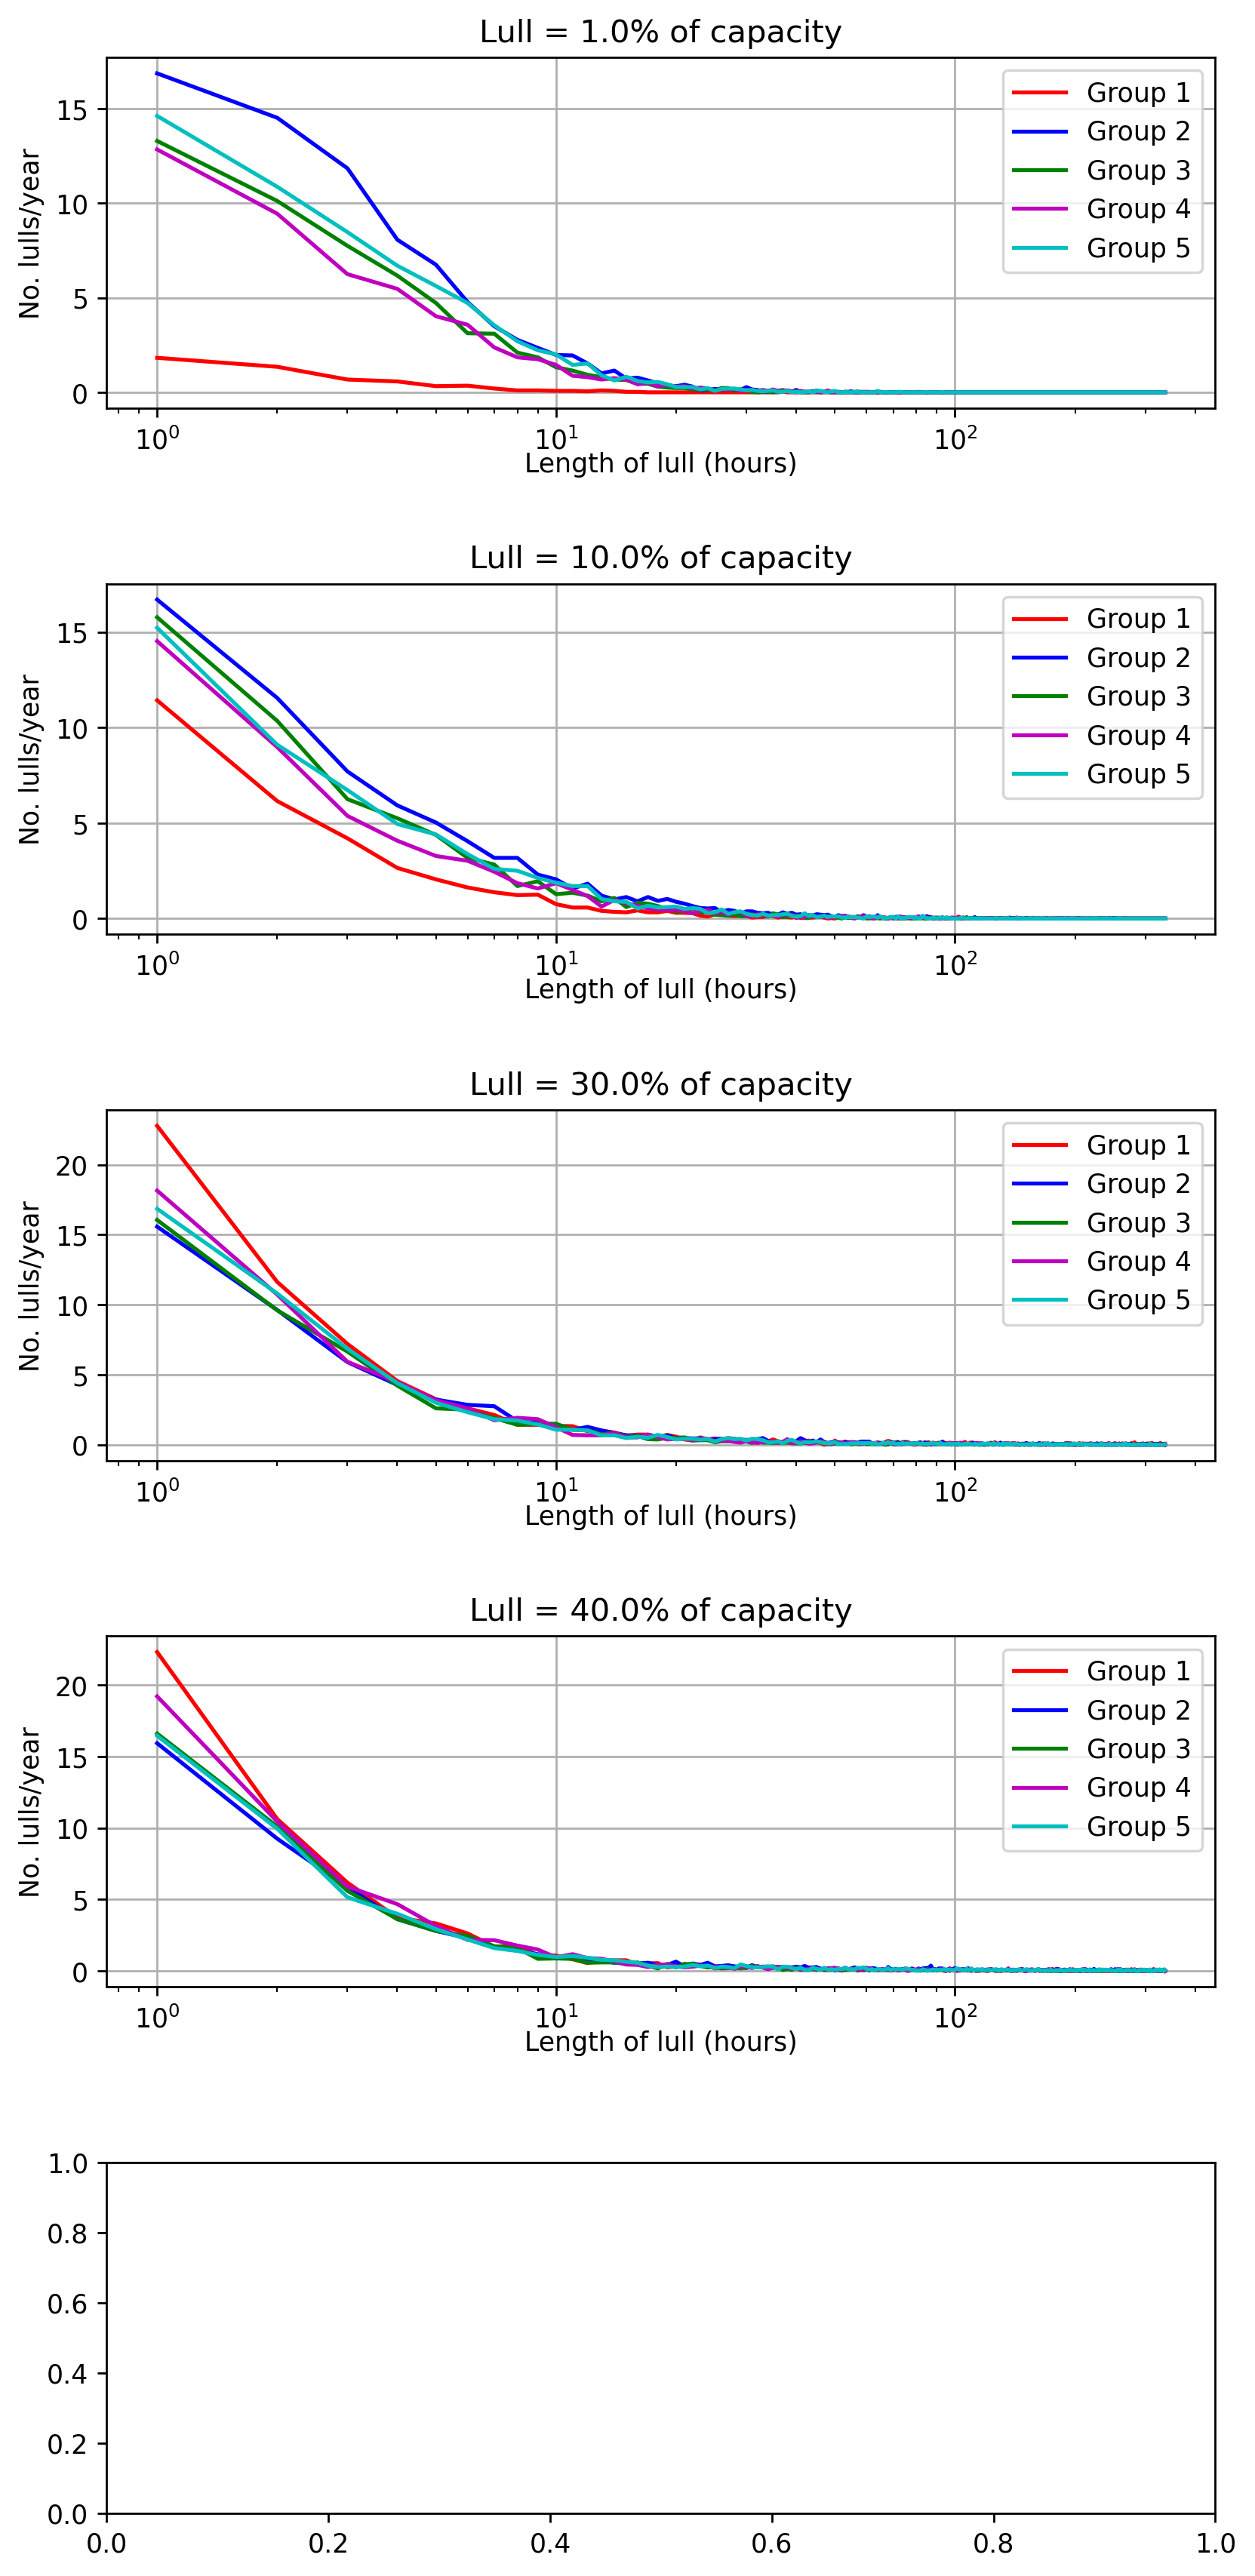

In [16]:
fig, ax = plt.subplots(5, dpi=250, figsize=(7, 14))
fig.tight_layout(pad=2.5)
plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

for k in range(cut_offs.shape[0]):
    ax[k].set_xlabel('Length of lull (hours)', labelpad=-1)
    ax[k].set_ylabel('No. lulls/year')
    ax[k].grid()
    for j in range(coords.shape[0]):
        ax[k].semilogx(avg_nums, num_lulls[k, j, :] / num_yrs, label=f'Group {j+1}', color=color[j])
        ax[k].set_title(f'Lull = {cut_offs[k] * 100}% of capacity')
    ax[k].legend()


